# BEST MODEL
Paste parameters and workflow of best model here

In [78]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [79]:
# read in pickled features
df_sj = pd.read_pickle('./datasets/all_sj.pkl')
df_iq = pd.read_pickle('./datasets/all_iq.pkl')

total_cases = pd.read_csv('./datasets/dengue_labels_train.csv')
cases_sj = total_cases[total_cases['city'] == 'sj']['total_cases']
cases_iq = total_cases[total_cases['city'] == 'iq']['total_cases']

# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

## Train-Validation-Test Split
Because this is time-series data and the features set is dependent on the past, the train test split is very delicate. The validation and test feature set will actually draw from data in the past (rolling mean, std, etc.). Therefore, when creating the model, the entire dataset must be used. But I must be careful not to train the model on data from the 'future'.

In [80]:
# train test split
#sj

# choose split dates
sj_valid_split = '2003-4-20'
sj_test_split = '2008-4-27' # this will split between pre and post submission dates

# split into train, valid, test (no y)
sj_train = df_sj.loc[:sj_valid_split]
sj_Xtrain = sj_train
sj_ytrain = cases_sj[:len(sj_train)]

sj_valid = df_sj.loc[sj_valid_split : sj_test_split]
sj_Xvalid = sj_valid
sj_yvalid = cases_sj[len(sj_train):]

sj_test = df_sj.loc[sj_test_split:]
sj_Xtest = sj_test


In [81]:
#iq

# choose split dates
iq_valid_split = '2007-7-01'
iq_test_split = '2010-7-01' # this will split between pre and post submission dates

# split
iq_train = df_iq.loc[:iq_valid_split]
iq_Xtrain = iq_train
iq_ytrain = cases_iq[:len(iq_Xtrain)]

iq_valid = df_iq.loc[iq_valid_split : iq_test_split]
iq_Xvalid = iq_valid
iq_yvalid = cases_iq[len(iq_train):]

iq_test = df_iq.loc[iq_test_split:]
iq_Xtest = iq_test


## SJ

In [82]:
print (len(pd.get_dummies(sj_Xtrain['month'], prefix='month')), len(sj_ytrain.values))
print (len(pd.get_dummies(sj_Xvalid['month'], prefix='month')), len(sj_yvalid.values))

675 675
261 261


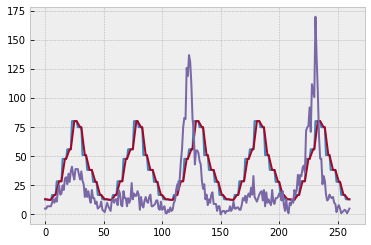

In [83]:
# sj monthly trend

lr_sj = LinearRegression()
X = pd.get_dummies(sj_Xtrain['month'], prefix='month')
y = sj_ytrain.values

lr_sj.fit(X, y)
monthly_trend_train = pd.Series(lr_sj.predict(X)).rolling(3, min_periods = 1).mean()
sj_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(sj_Xvalid['month'], prefix='month')
ytest = sj_yvalid.values
monthly_trend_valid = pd.Series(lr_sj.predict(Xtest)).rolling(3, min_periods=1).mean()
sj_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_sj.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

# print mean_absolute_error(lr_sj.predict(Xtest), ytest)
# print mean_absolute_error(monthly_trend_valid, ytest)

-16.083333333333332
675 261


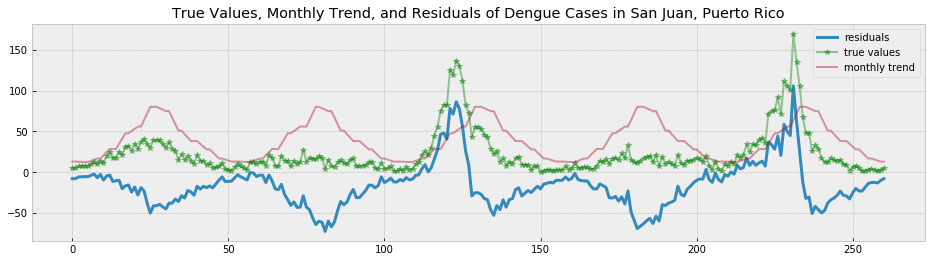

In [84]:
# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(sj_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in San Juan, Puerto Rico')
plt.legend()
print (np.mean(sj_residuals_test))

print (len(sj_residuals_train), len(sj_residuals_test))

## PREDICT THE BLUE!!!

## Test on valid from grid search results
use values from 3 tables above

615 615
201 201
25.638988551204054
-0.10420015295807894


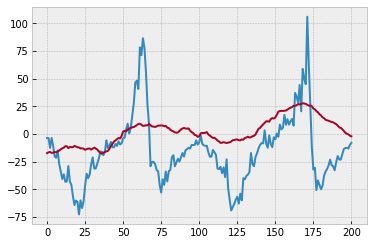

In [85]:
# munge data

# max roll back set to 59

# rolling means df
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[60:675]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 10).mean()[60:675]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_train[60:]

print (len(Xtrain), len(ytrain))

# rolling means df
Xvalid_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[675:936]
Xvalid_means2 = df_sj['ndvi_se'].rolling(window = 10).mean()[675:936]

# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = sj_residuals_test[60:]

print (len(Xvalid), len(yvalid))

# fit on model, predict
lr_sj_residual = LinearRegression()
lr_sj_residual.fit(Xtrain, ytrain)

sj_valid_preds = lr_sj_residual.predict(Xvalid)

print (mean_absolute_error(sj_valid_preds, yvalid))
print (lr_sj_residual.score(Xvalid, yvalid))
plt.plot(yvalid.values)
plt.plot(sj_valid_preds)

### Notes:

* I will slowly add more features to this graph

## IQ

Do the same as I did for SJ above, but to see which IQ features explain the variance in the residuals.

In [86]:
print (len(pd.get_dummies(iq_Xtrain['month'], prefix='month')), len(iq_ytrain.values))
print (len(pd.get_dummies(iq_Xvalid['month'], prefix='month')), len(iq_yvalid.values))

364 364
156 156


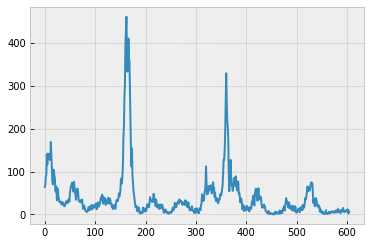

In [87]:
plt.plot(y[70:])

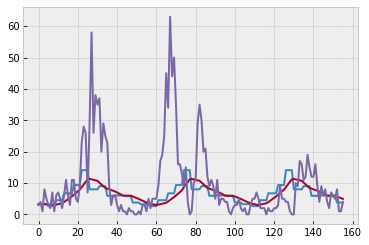

7.066100566100565
6.9319898520791385


In [88]:
# iq monthly trend

lr_iq = LinearRegression()
X = pd.get_dummies(iq_Xtrain['month'], prefix='month')
y = iq_ytrain.values

lr_iq.fit(X, y)
monthly_trend_train = pd.Series(lr_iq.predict(X)).rolling(9, min_periods = 1).mean()
iq_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(iq_Xvalid['month'], prefix='month')
ytest = iq_yvalid.values
monthly_trend_valid = pd.Series(lr_iq.predict(Xtest)).rolling(9, min_periods=1).mean()
iq_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_iq.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

print (mean_absolute_error(lr_iq.predict(Xtest), ytest))
print (mean_absolute_error(monthly_trend_valid, ytest))

3.4354563591170724


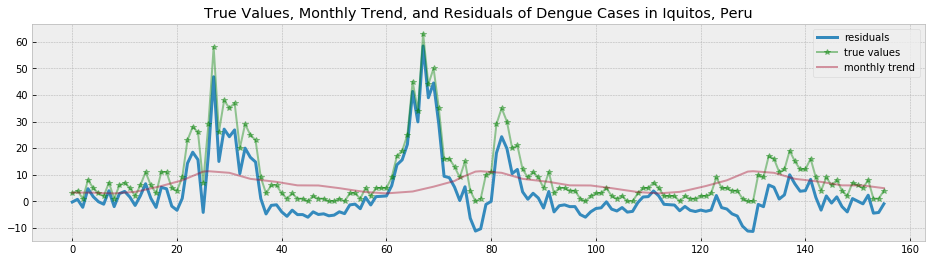

In [89]:
# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(iq_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in Iquitos, Peru')
plt.legend()
print (np.mean(iq_residuals_test))

## PREDICT THE BLUE!!!
# Note: the monthly predictions for iq are pretty bad over the validation set...

## predict the residuals based on rolling weather features

In [90]:
len(Xtrain)
len(ytrain)

615

304 304
96 96
0.05669052939543262
6.965214878628129


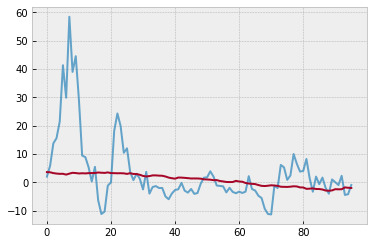

In [91]:
# rolling mean of feature to predict residuals

# munge data

# max roll back set to 59

# set up training data
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[60:364]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_train[60:]

print (len(Xtrain), len(ytrain))

# set up validation data
# rolling means df
Xvalid_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[364:520]

# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = iq_residuals_test[60:]

print (len(Xvalid), len(yvalid))

# model it!

lr_iq_resids = LinearRegression()
lr_iq_resids.fit(Xtrain, ytrain)

iq_valid_preds = lr_iq_resids.predict(Xvalid)

# plot iq residual predictions
plt.plot(yvalid.values, alpha = .75)
plt.plot(iq_valid_preds)
print (lr_iq_resids.score(Xvalid, yvalid))
print (mean_absolute_error(iq_valid_preds, yvalid))

### Notes:

* IQ resiuduals is much more erratic and harder to predict
* Tweak these features more

## USE TEST DATA, MAKE CSV OF SUBMISSIONS

Need to use full dataset (train + test) because values depend on previous weather data

In [92]:
# transform sj data

month_dums = pd.get_dummies(df_sj['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_sj[['station_avg_temp_c']].rolling(window = 55).mean())
# temp_roll_std = pd.DataFrame(df_sj[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test set
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)

# train model
lr_sj_full = LinearRegression()
lr_sj_full.fit(Xtest[60:-260], cases_sj.values[60:])

# predicts
sj_full_preds = lr_sj_full.predict(Xtest[55:])
sj_submit_preds = sj_full_preds[-260:]

25.76411748013621


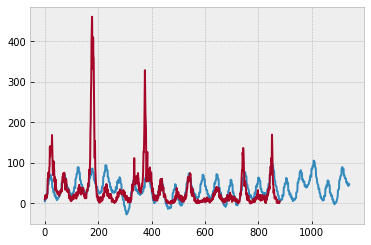

In [93]:
plt.plot(sj_full_preds)
plt.plot(cases_sj.values[55:])
print (mean_absolute_error(sj_full_preds[:-260], cases_sj.values[55:]))

In [94]:
# transform iq data
month_dums = pd.get_dummies(df_iq['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_iq[['ndvi_nw']].rolling(window = 68).mean())
# temp_roll_std = pd.DataFrame(df_iq[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)

# train
lr_iq_full = LinearRegression()
lr_iq_full.fit(Xtest[68:-156], cases_iq.values[68:])

# predicts
iq_full_preds = lr_iq_full.predict(Xtest[68:])
iq_submit_preds = iq_full_preds[-156:]

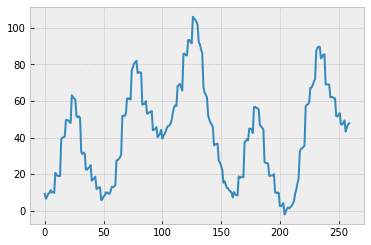

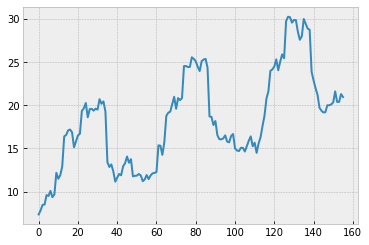

In [95]:
plt.plot(sj_submit_preds)
plt.show()
plt.plot(iq_submit_preds)
plt.show()

In [96]:
total_preds = list(sj_submit_preds) + list(iq_submit_preds)

### make csv

In [97]:
# submission
submission_format = pd.read_csv('./../original data_set/submission_format.csv')

In [98]:
submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

In [99]:
# Save to CSV, use current date
# submission_format.to_csv('submissions/dengue_submission_9_12_17v1.csv', index=False)

## Make predictions v2
Predict the residuals, then add them to the monthly trend

### San Juan

In [100]:
# get monthly trend of whole test df
lr_sj_month = LinearRegression()
X_months = pd.get_dummies(df_sj['month'], prefix='month')[:936]
Xtest_months = pd.get_dummies(df_sj['month'], prefix='month')[936:]
y = cases_sj.values

lr_sj_month.fit(X_months, y)
monthly_trend = pd.Series(lr_sj_month.predict(X_months)).rolling(3, min_periods=1).mean()
sj_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[60:936]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 25).mean()[60:936]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[936:]
Xtest_means2 = df_sj['ndvi_se'].rolling(window = 25).mean()[936:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)

# fit on model
lr_sj_resid = LinearRegression()
lr_sj_resid.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [101]:
# make predictions on monthly data and residual data
sj_monthly_preds = pd.Series(lr_sj_month.predict(Xtest_months)).rolling(3, min_periods=1).mean()
sj_resid_preds = lr_sj_resid.predict(Xtest_weather)
sj_cases_pred = pd.Series(sj_resid_preds + sj_monthly_preds).rolling(1, min_periods=1).mean()
sj_cases_pred = sj_cases_pred.apply(lambda x: 1 if x < 1 else int(x))

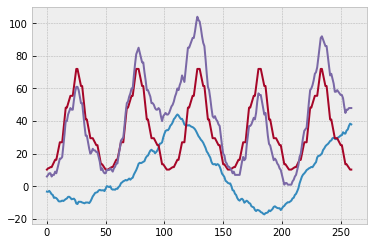

In [102]:
plt.plot(sj_resid_preds)
plt.plot(sj_monthly_preds)
plt.plot(sj_cases_pred)

Text(0,0.5,'Cases')

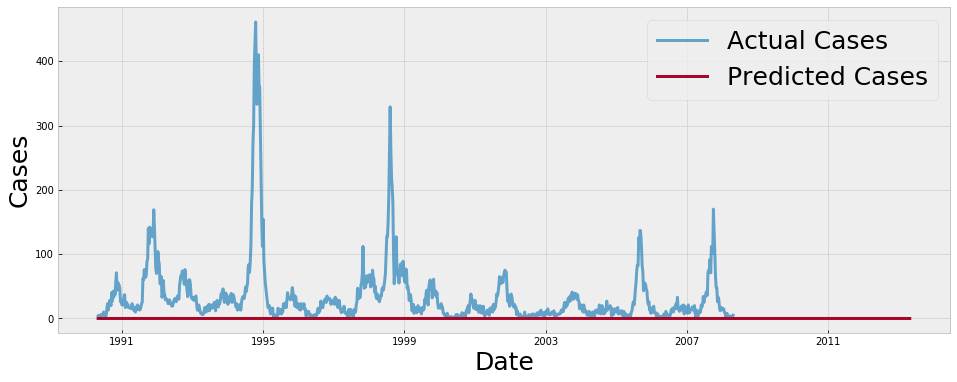

In [103]:
### make plot of best model predictions and actual cases over all time period for sj

# monthly trend
sj_month_preds = lr_sj_month.predict(pd.get_dummies(df_sj['month'], prefix='month'))
# predicted residuals
weather1 = df_sj[['station_avg_temp_c']].rolling(window=53, min_periods=1).mean()
weather2 = df_sj[['ndvi_se']].rolling(window=10, min_periods=1).mean()
weather_all = pd.concat([weather2], axis = 1)
sj_resid_predicts = lr_sj_resid.predict(weather_all)
# monthly + residuals
pred_cases = pd.Series(sj_month_preds + sj_resid_predicts)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)

plt.figure(figsize=(16, 6))
plt.plot(df_sj.index[:936], cases_sj, label = 'Actual Cases', linewidth = 3, alpha = .75)
plt.plot(df_sj.index, pred_cases, label = 'Predicted Cases', linewidth = 3)

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)

### Iquitos

In [104]:
len(cases_iq)

520

In [105]:
# get monthly trend of whole test df
lr_iq_month = LinearRegression()
X_months = pd.get_dummies(df_iq['month'], prefix='month')[:520]
Xtest_months = pd.get_dummies(df_iq['month'], prefix='month')[520:]
y = cases_iq.values

lr_iq_month.fit(X_months, y)
monthly_trend = pd.Series(lr_iq_month.predict(X_months)).rolling(8, min_periods=1).mean()
iq_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[60:520]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[520:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)

# fit on model
lr_iq_resid = LinearRegression()
lr_iq_resid.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [106]:
# make predictions on monthly data and residual data
iq_monthly_preds = pd.Series(lr_iq_month.predict(Xtest_months)).rolling(8, min_periods=1).mean()
iq_resid_preds = lr_iq_resid.predict(Xtest_weather)
iq_cases_pred = pd.Series(iq_monthly_preds + iq_resid_preds)
iq_cases_pred = iq_cases_pred.apply(lambda x: 0 if x < 1 else int(x))

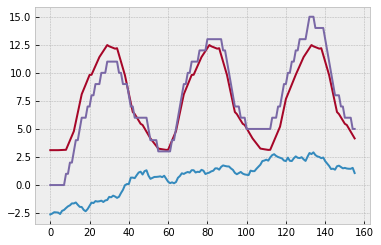

In [107]:
plt.plot(iq_resid_preds)
plt.plot(iq_monthly_preds)
plt.plot(iq_cases_pred)

Text(0,0.5,'Cases')

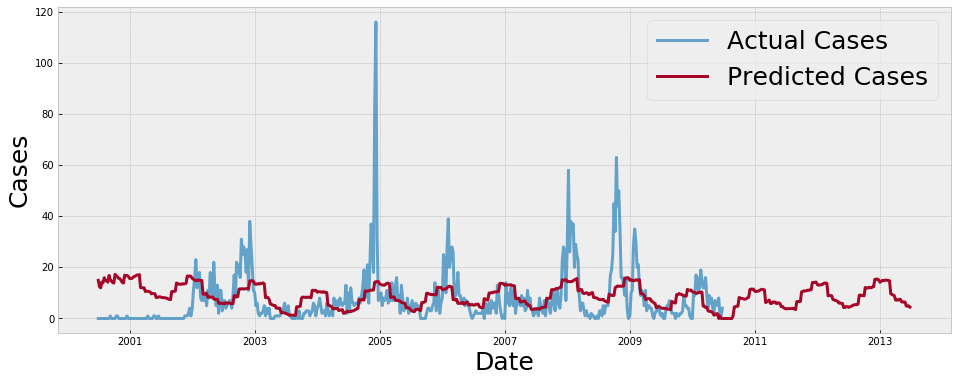

In [108]:
### make plot of best model predictions and actual cases over all time period for iq

# monthly trend
iq_month_preds = lr_iq_month.predict(pd.get_dummies(df_iq['month'], prefix='month'))
# predicted residuals
weather1 = df_iq[['station_avg_temp_c']].rolling(window=53, min_periods=1).mean()
weather2 = df_iq[['ndvi_se']].rolling(window=10, min_periods=1).mean()
weather_all = pd.concat([weather1], axis = 1)
iq_resid_predicts = lr_iq_resid.predict(weather_all)
# monthly + residuals
pred_cases = pd.Series(iq_month_preds + iq_resid_predicts)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)

plt.figure(figsize=(16, 6))
plt.plot(df_iq.index[:520], cases_iq, label = 'Actual Cases', linewidth = 3, alpha = .75)
plt.plot(df_iq.index, pred_cases, label = 'Predicted Cases', linewidth = 3)

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)

### make csv

In [109]:
total_preds = list(sj_cases_pred) + list(iq_cases_pred)

In [110]:
# submission
submission_format = pd.read_csv('./../original data_set/submission_format.csv')

In [111]:
submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

In [112]:
# Save to CSV, use current date
submission_format.to_csv('submission.csv', index=False)

In [113]:
submission_format.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,7
2,sj,2008,20,8
3,sj,2008,21,8
4,sj,2008,22,6


### Submitted MAEs!!!!
* monthly trend and mean `station_avg_temp_c` with window = 52 was 20.7764
* monthly trend and mean `station_avg_temp_c` with window = 52 and std window = 8 was 20.7981
* monthly trend and mean `station_avg_temp_c` and `precipitation_amt_mm` with window = 52 and std window = 8 was 24.1274
* monthly trend and sj used mean `station_avg_temp_c` with window = 55 and iq used 'ndvi_nw' with window = 68 was 23.5697
* monthly trend and sj used mean `station_avg_temp_c` with window = 55 and `ndvi_se` with window = 10 and iq used 'ndvi_nw' with window = 68 was 21.337
* Next steps: use other rolling features (and std? and shifted? and exponentially weighted mean?)